In [16]:
using BenchmarkTools, QuadGK, PyPlot, LinearAlgebra, Base.MathConstants
import Polynomials

In [5]:
function E₁_cf(z::Number, n::Integer, start::Number=z)
    # starting with z seems to give many fewer terms for intermediate |z| ~ 3
    cf::typeof(inv(z)) = start
    for i = n:-1:1
        cf = z + (1+i)/cf
        cf = 1 + i/cf
    end
    return exp(-z) / (z + inv(cf))
end

function E₁_cf_nterms(z::Number, reltol=1e-14, start=z)
    for n = 1:100 # give up after 100 terms
        doubled = E₁_cf(z, 2n, start)
        if abs(E₁_cf(z, n, start) - doubled) ≤ reltol*abs(doubled)
            return n
        end
    end
    return 101
end

E₁_cf_nterms (generic function with 3 methods)

Iterations to convergence for $z=3-3i$ by continued fraction starting point

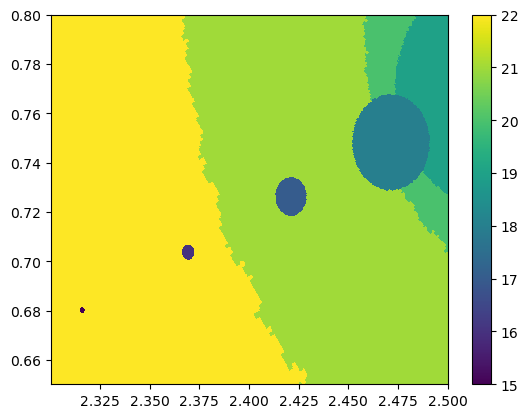

PyObject <matplotlib.colorbar.Colorbar object at 0x1a4ea9dd0>

In [6]:
pt = 3.0 - 3.0im
#re_ax = range(-1.5, 2*real(pt)+1, length=1000)[2:end]
#im_ax = range(-1.5, 2*imag(pt)+1, length=1000)[2:end]
re_ax = range(2.3, 2.5, length=1500)[2:end]
im_ax = range(0.65,0.8, length=1500)[2:end]
Ns = [E₁_cf_nterms(pt, 1e-14, x + y*im) for y in im_ax, x in re_ax]
pcolor(re_ax', im_ax, Ns)
colorbar()

Magnified plot of iterations vs start point for a few nearby real inputs. Shows very narrow bands
where convergence is drastically faster. Bands become narrower as fewer iterations are needed.

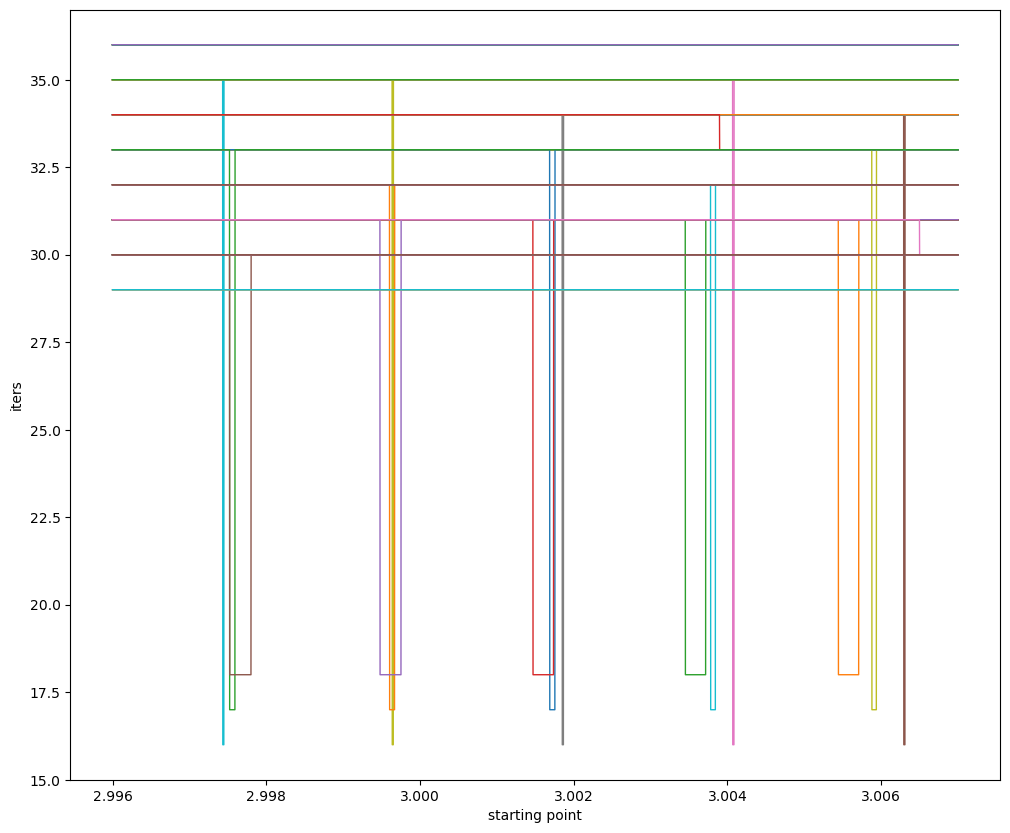

PyObject Text(24.000000000000007, 0.5, 'iters')

In [8]:
fig = figure(figsize=(12,10))
for z = range(2.5, 3.1, length=120)
    a, b = 2.996, 3.007
    grid_pts = range(a, b, length=10_000)
    Ns = E₁_cf_nterms.(z, 1e-15, grid_pts)
    plot(grid_pts, Ns, linewidth=1, label="z=$z")
    best_start = grid_pts[argmin(Ns)]
end
xlabel("starting point")
ylabel("iters")

Finds coefficients to use for starting polynomial in CF for a given input range, accuracy,
and number of iterations.

In [9]:
samples = range(3, 4, length=200)
input_pts = Float64[]
start_pts = Float64[]
ranges = []
for z = samples
    grid_pts = range(2.0, 4.6, length=12_000)
    Ns = E₁_cf_nterms.(z, 1e-15, grid_pts)
    good_idx = (Ns .== 16)
    good_pts = grid_pts[good_idx]
    if length(good_pts) < 1
        continue
    else
        #reps = 10 / length(good_pts)
        #reps = reps < 1 ? 1 : reps
        pt = mean(good_pts)
        mi, ma = minimum(good_pts), maximum(good_pts)
        push!(ranges, (z, mi, ma))
        reps=1
        for i = 1:reps
            push!(input_pts, z)
            push!(start_pts, pt)
        end
    end
end

# solve LSQ
A = hcat(ones(length(input_pts)), input_pts, input_pts.^2, input_pts.^3)#, input_pts.^4)
coeffs = A \ start_pts
fxx(x, cfs) = cfs[1] + x*cfs[2] + x*x*cfs[3] + x*x*x*cfs[4]# + x*x*x*x*cfs[5]

errs = abs.( (A * coeffs) - start_pts )
minimum(errs), maximum(errs), coeffs

(5.185752867120641e-7, 0.00015040422557488498, [5.082937574893669, -1.2528537987497932, 0.21348911904194345, -0.014413096602182719])

In [10]:
function E₁_cfpoly_start(n::Integer, pstart, ::Type{T}=BigInt) where {T<:Real}
    q = Polynomials.Poly(T[1])
    x = Polynomials.Poly(T[0,1])
    p = pstart
    for i = n:-1:1
        p, q = x*p+(1+i)*q, p # from cf = x + (1+i)/cf = x + (1+i)*q/p
        p, q = p + i*q, p     # from cf = 1 + i/cf = 1 + i*q/p
    end
    # do final 1/(x + inv(cf)) = 1/(x + q/p) = p/(x*p + q)
    return p, x*p + q
end

function eval_with_coeffs(z, n, coeffs)
    p, q = E₁_cfpoly_start(n, Polynomials.Poly(coeffs))
    num, den = Float64.(p.coeffs), Float64.(q.coeffs)
    #println(Polynomials.degree.((p, q)))
    return exp(-z) * evalpoly(z, num) / evalpoly(z, den)
end

eval_with_coeffs (generic function with 1 method)

In [11]:
function E₁_slow(z::Union{T,Complex{T}}) where {T<:AbstractFloat}
    real(z) < 0 && error("real(z) < 0 not implemented")
    return quadgk(u -> exp(-z/u)/u, 0, 1, rtol=eps(T)*10)[1]
end
E₁_slow(z::Union{T,Complex{T}}) where {T<:Real} = E₁_slow(float(z))

E₁_slow (generic function with 2 methods)

Relative error using coefficients chosen specially for $3 < x < 4$

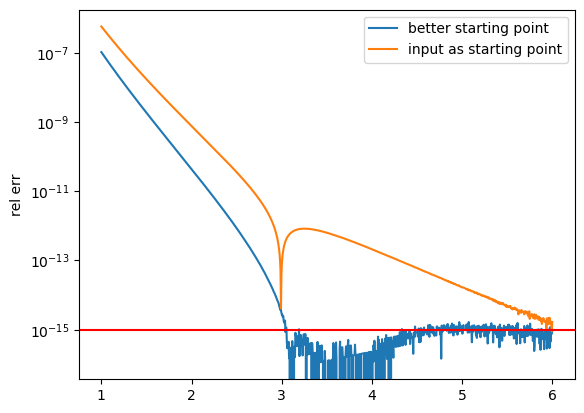

PyObject <matplotlib.legend.Legend object at 0x164eeda90>

In [26]:
xr = range(1, 6, length=1000)
ress1 = eval_with_coeffs.(xr, 16, Ref(coeffs))
ress2 = E₁_slow.(xr)
ress3 = eval_with_coeffs.(xr, 18, Ref([0,1]))
err1 = @. abs(ress1 - ress2)/ress2
err2 = @. abs(ress3 - ress2)/ress2
semilogy(xr, err1, label="better starting point")
semilogy(xr, err2, label="input as starting point")
axhline(1e-15, color="red")
ylabel("rel err")
legend()